In [16]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# read in training and test data and labels
X_train = pd.read_csv("Xtrain.csv",header=None)
y_train = pd.read_csv("ytrain.csv",header=None)
X_test = pd.read_csv("Xtest.csv",header=None)
y_test = pd.read_csv("ytest.csv",header=None)
# read in the matrix of eigenvectors that is used to map the 15-dimensional feature vectors back into image space
Q = pd.read_csv("Q.csv",header=None)

In [17]:
# initialize parameters and functions (calculating expectation of phi w.r.t q, vector w, log joint likelihood)
# for E-step and M-step: 

sigma = 1.5
lamda = 1.0
T = 100
d = X_train.shape[1]
N = X_train.shape[0]
# w_matrix = pd.DataFrame(np.zeros((T+1, d)))
w_matrix = np.zeros((T+1, d))
# phi_expectation = np.zeros(N)
log_joint_likelihood = np.zeros(T+1)

In [18]:
# implementation with matrix manipulation instead of for loop over each training instance:

for t in range(0, T+1):
    if t == 0:
        log_joint_likelihood[t] = d*(np.log(lamda/(2*math.pi)))/2.0 - lamda*(np.dot(w_matrix[t,:], w_matrix[t,:]))/2.0 + \
            np.dot(np.transpose(y_train), np.log(norm.cdf(pd.DataFrame(np.dot(X_train, w_matrix[t,:])/sigma)))) + \
            np.dot(1 - np.transpose(y_train), np.log(norm.cdf(pd.DataFrame(np.dot(X_train, w_matrix[t,:])/sigma))))
            
    else:
        phi_expectation = np.power((pd.DataFrame(np.dot(X_train, w_matrix[t-1,:])) + sigma * norm.pdf(-pd.DataFrame(np.dot(X_train, w_matrix[t-1,:])/sigma)) / \
            (1 - norm.cdf(-pd.DataFrame(np.dot(X_train, w_matrix[t-1,:])/sigma)))), y_train) * \
            np.power((pd.DataFrame(np.dot(X_train, w_matrix[t-1,:])) + sigma * (-norm.pdf(-pd.DataFrame(np.dot(X_train, w_matrix[t-1,:])/sigma))) / \
                      (norm.cdf(-pd.DataFrame(np.dot(X_train, w_matrix[t-1,:])/sigma)))), 1 - y_train)

        w_matrix[t,:] = np.dot(np.linalg.inv(lamda * np.identity(d) + np.dot(np.transpose(X_train), X_train)/(sigma**2)), \
            np.dot(np.transpose(X_train), phi_expectation) / (sigma**2)).flatten()


        log_joint_likelihood[t] = d*(np.log(lamda/(2*math.pi)))/2.0 - lamda*(np.dot(w_matrix[t,:], w_matrix[t,:]))/2.0 + \
            np.dot(np.transpose(y_train), np.log(norm.cdf(pd.DataFrame(np.dot(X_train, w_matrix[t,:])/sigma)))) + \
            np.dot(1 - np.transpose(y_train), np.log(1 - norm.cdf(pd.DataFrame(np.dot(X_train, w_matrix[t,:])/sigma))))

In [19]:
train_pred = norm.cdf(np.dot(X_train, w_matrix[T,:])/sigma)
test_pred = norm.cdf(np.dot(X_test, w_matrix[T,:])/sigma)

In [20]:
# a)

train_pred_binary = (train_pred > 0.5).astype(int)
print ((train_pred_binary == y_train.loc[:,0]).sum())/float(y_train.shape[0])

test_pred_binary = (test_pred > 0.5).astype(int)
print ((test_pred_binary == y_test.loc[:,0]).sum())/float(y_test.shape[0])

0.938427614282
0.935208437971


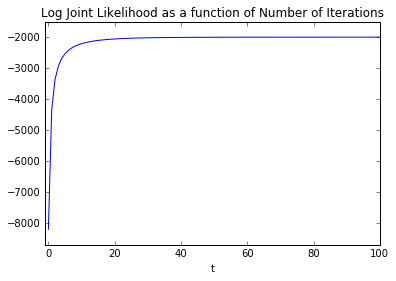

In [21]:
# b)

axes = plt.gca()
axes.set_xlim([-1,100])
axes.set_ylim([log_joint_likelihood[0]-500,log_joint_likelihood[100]+500])
axes.set_xlabel('t')
plt.plot(log_joint_likelihood)
plt.title('Log Joint Likelihood as a function of Number of Iterations')
plt.show()

In [22]:
# c)

# use scikit-learn to calculate confusion matrix:
from sklearn.metrics import confusion_matrix
y_true = y_test.loc[:,0]
y_pred = test_pred_binary
confusion_matrix(y_true, y_pred)
# Note that C_{i, j} is equal to the number of observations known to be in group i but predicted to be in group j.

array([[930,  52],
       [ 77, 932]])

In [23]:
# d) 

misClassification_indices = y_test[test_pred_binary != y_test.loc[:,0]].index.tolist()
misC_pic_first3_features = np.transpose(X_test.loc[misClassification_indices[0:3],:])
misC_pic_first3 = Q.dot(misC_pic_first3_features)

In [24]:
misClassification_indices[0:3]

[40, 46, 64]

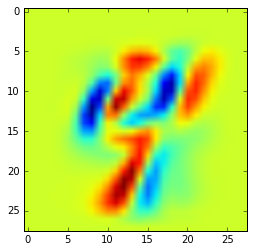

In [25]:
plt.imshow(np.reshape(misC_pic_first3.loc[:,misClassification_indices[0]], (28, 28)))
plt.show()

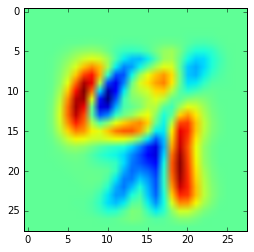

In [26]:
plt.imshow(np.reshape(misC_pic_first3.loc[:,misClassification_indices[1]], (28, 28)))
plt.show()

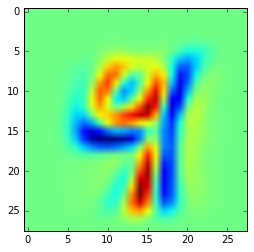

In [27]:
plt.imshow(np.reshape(misC_pic_first3.loc[:,misClassification_indices[2]], (28, 28)))
plt.show()

In [28]:
# predicted probability that image belongs to Class 1:
test_pred[misClassification_indices[0:3]]

array([ 0.67717963,  0.69821969,  0.90578124])

In [29]:
# e)

N_test = X_test.shape[0]
ambiguous_3_indices = pd.DataFrame(abs(test_pred - 0.5).reshape(N_test, 1)).loc[:,0].sort_values().index.tolist()[0:3]
ambiguous_3_indices

[586, 340, 210]

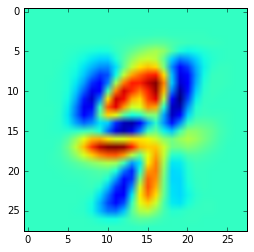

In [31]:
m1 = np.transpose(X_test.loc[ambiguous_3_indices[0],:])
m2 = Q.dot(m1)
plt.imshow(np.reshape(m2, (28, 28)))

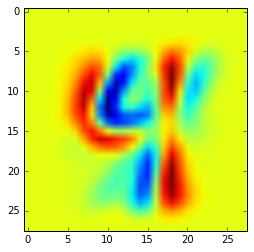

In [32]:
m1 = np.transpose(X_test.loc[ambiguous_3_indices[1],:])
m2 = Q.dot(m1)
plt.imshow(np.reshape(m2, (28, 28)))

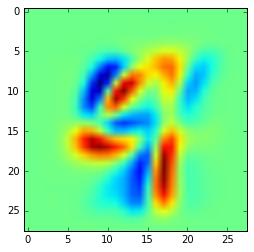

In [33]:
m1 = np.transpose(X_test.loc[ambiguous_3_indices[2],:])
m2 = Q.dot(m1)
plt.imshow(np.reshape(m2, (28, 28)))

In [34]:
test_pred[ambiguous_3_indices]

array([ 0.50017366,  0.50309983,  0.50411734])

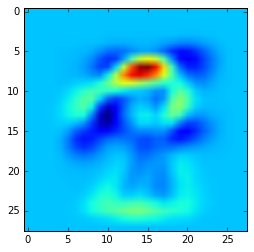

In [35]:
# f)

# t = 1, 5, 10, 25, 50, 100
plt.imshow(np.reshape(Q.dot(w_matrix[1,:]), (28, 28)))

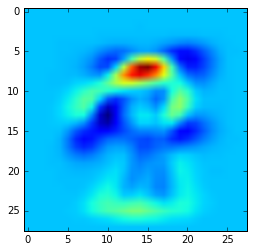

In [36]:
plt.imshow(np.reshape(Q.dot(w_matrix[5,:]), (28, 28)))

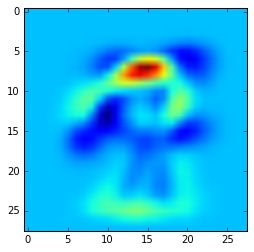

In [37]:
plt.imshow(np.reshape(Q.dot(w_matrix[10,:]), (28, 28)))

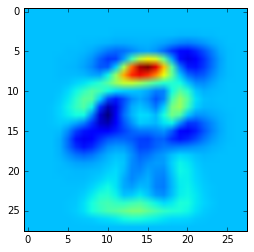

In [38]:
plt.imshow(np.reshape(Q.dot(w_matrix[25,:]), (28, 28)))

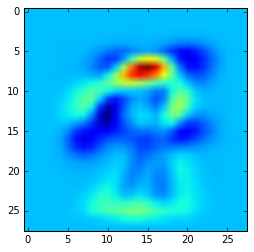

In [39]:
plt.imshow(np.reshape(Q.dot(w_matrix[50,:]), (28, 28)))

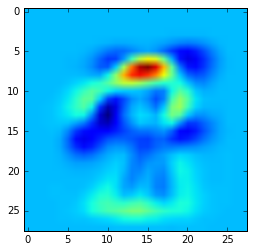

In [40]:
plt.imshow(np.reshape(Q.dot(w_matrix[100,:]), (28, 28)))